In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
df = pd.read_csv("uci-secom.csv")
df.shape

(1567, 592)

In [3]:
df.head(1)

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.0,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.363,NaN,NaN,NaN,NaN,-1


<Axes: >

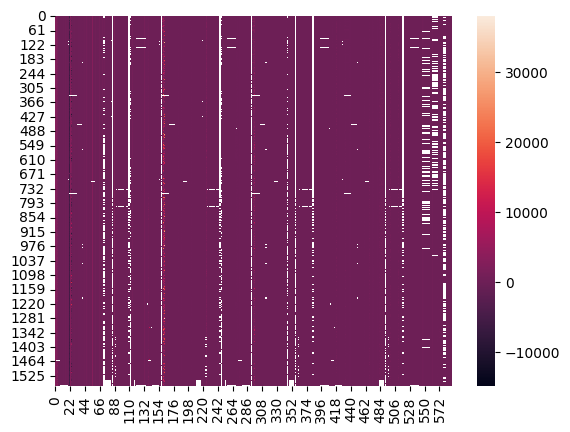

In [4]:
sns.heatmap(df.select_dtypes(include="number"))

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


In [6]:
df.isnull().sum()

Time          0
0             6
1             7
2            14
3            14
             ..
586           1
587           1
588           1
589           1
Pass/Fail     0
Length: 592, dtype: int64

In [7]:
label_name = "Pass/Fail"

In [8]:
label_one_count = (df[label_name] == 1).sum()
label_one_count

104

In [9]:
df_label_not_one = df[df[label_name] == -1].sample(label_one_count)

In [10]:
df_under = pd.concat([df_label_not_one,  df[df[label_name] == 1]])
df_under.shape

(208, 592)

In [11]:
df_under[label_name].value_counts()

Pass/Fail
-1    104
 1    104
Name: count, dtype: int64

In [12]:
X, y = df_under.drop(columns=[label_name, "Time"]), df_under[label_name]
X.shape, y.shape

((208, 590), (208,))

<Axes: >

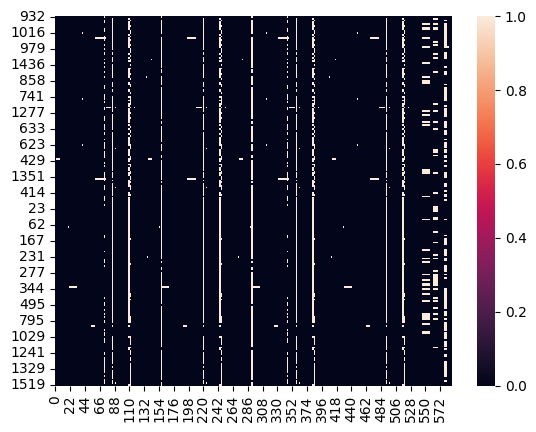

In [13]:
sns.heatmap(X.isnull())

In [14]:
X = X.fillna(0)
X.isnull().sum().sum()

0

## data split

In [15]:
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, stratify=y, test_size=0.1, random_state=42)

In [16]:
# Tensor 변환
X_train = torch.Tensor(X_train_raw.values)
X_valid = torch.Tensor(X_test_raw.values)

X_train.shape

torch.Size([187, 590])

In [17]:
# Label
y_train = torch.Tensor(y_train_raw.values)
y_valid = torch.Tensor(y_test_raw.values)
print(y_train.shape, y_valid.shape)
y_train[:5]

torch.Size([187]) torch.Size([21])


tensor([-1., -1., -1., -1., -1.])

In [18]:
y_train.shape

torch.Size([187])

## model

In [19]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.seq(x)
        return x

# 모델 초기화
input_size = X_train.shape[1]
model = LogisticRegression(input_size)

# 손실 함수 및 optimizer 설정
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

optimizer에 등록된 모든 매개변수의 gradient를 0으로 초기화하는 메서드입니다. 이를 호출하지 않으면, backward() 함수 호출 시 이전에 계산된 gradient 값과 현재 gradient 값이 누적되어 학습이 제대로 이루어지지 않을 수 있습니다.

따라서 모델의 학습을 시작하기 전에, optimizer.zero_grad()를 호출하여 gradient 값을 초기화해야 합니다. 예를 들어, 다음과 같은 코드에서는 각 학습 루프(iteration)마다 optimizer.zero_grad()를 호출하여 gradient를 초기화합니다.

## train

In [20]:
# 모델 초기화
input_size = X_train.shape[1]
model = LogisticRegression(input_size)

# 손실 함수 및 optimizer 설정
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습
num_epochs = 1000
best_val_loss = 0.0
num_bad_epochs = 0
early_stop_patience = 50
for epoch in range(num_epochs):
    # forward + backward + optimize
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)
    loss.backward()
    optimizer.step()

    # 중간 결과 출력
    if (epoch+1) % 100 == 0:
        print('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

    # 검증 데이터에 대한 성능 측정
    with torch.no_grad():
        model.eval()
        val_outputs = model(X_valid)
        val_loss = criterion(val_outputs.squeeze(), y_valid)

        # 검증 데이터에 대한 정확도 계산
        val_preds = (val_outputs > 0.5).float()
        val_acc = (val_preds == y_valid).float().mean()

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss.item():.4f}, Val Acc: {val_acc.item():.4f}')

        # 검증 데이터에 대한 Loss 가 early_stop_patience번 연속 개선되지 않으면 조기 종료
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            num_bad_epochs = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            num_bad_epochs += 1
            if num_bad_epochs == early_stop_patience:
                print("Early stopping")
                break

Epoch [10/1000], Val Loss: 0.6931, Val Acc: 0.0000
Epoch [20/1000], Val Loss: 0.6931, Val Acc: 0.0000
Epoch [30/1000], Val Loss: 0.6931, Val Acc: 0.0000
Epoch [40/1000], Val Loss: 0.6931, Val Acc: 0.0000
Epoch [50/1000], Val Loss: 0.6931, Val Acc: 0.0000
Early stopping



모델이 nan을 반환한다면

* 학습률이 너무 크거나 작음
* Gradient가 폭주하거나 소실
* 데이터가 너무 불균형하거나 잘못된 처리가 있을 수 있음

다음의 방법을 시도해 볼 수 있음

* Gradient Clipping: gradient 값을 일정 범위로 제한하여 너무 큰 gradient로 인해 발생하는 문제를 해결할 수 있습니다.
* Weight Initialization: 모델 파라미터의 초기값을 조정하여 학습이 잘 이루어지도록 돕는 방법입니다.
* Learning Rate Scheduler: 학습이 진행됨에 따라 learning rate를 감소시키는 방법입니다. 처음에는 큰 learning rate로 학습을 시작하다가, 학습이 진행될수록 learning rate를 작게 조정하면, 모델의 성능을 높일 수 있습니다.
* Regularization: 모델의 overfitting을 막는 방법으로, L1/L2 regularization, dropout, batch normalization 등이 있습니다.

## Validation

* torch.no_grad()는 PyTorch에서 gradient 계산을 수행하지 않도록 하는 context manager입니다. 이를 사용하면 모델의 inference 과정에서 gradient 계산을 하지 않아 메모리 사용량을 줄일 수 있습니다. 또한 gradient 계산이 필요하지 않은 validation, test 데이터셋 등에서 사용하여 불필요한 계산을 방지할 수 있습니다.


In [21]:
with torch.no_grad():
    outputs = model(X_valid)
    y_valid_predict = (outputs >= 0.5).float()
    y_valid_predict = y_valid_predict.squeeze()
    
(y_valid.squeeze() == y_valid_predict).numpy().mean()

0.0